## 1- Import Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder, PowerTransformer,RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, f1_score, accuracy_score, jaccard_score, SCORERS
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pickle import dump, load
from xgboost import XGBRegressor, plot_importance
from sklearn import tree
from scipy import stats
from scipy.stats import boxcox
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from sklearn.tree import plot_tree

In [2]:
#Disable the max columns and rows to be viewed in Pandas Dataframes
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
df = pd.read_csv("C:\\Users\\mosta\\Downloads\\train.csv")

In [4]:
#Separate independent variables from the dependent variable
x, y = df.iloc[:, :-1], df.iloc[:, [-1]]

In [5]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [6]:
print(f"Shape of x_train is: {x_train.shape}\nShape of x_test is: {x_test.shape} \nShape of y_train is: {y_train.shape} \nShape of y_test is: {y_test.shape}")

Shape of x_train is: (1168, 80)
Shape of x_test is: (292, 80) 
Shape of y_train is: (1168, 1) 
Shape of y_test is: (292, 1)


## 2- Exploratory Data Analysis

### Data Types

In [7]:
categorical = [x for x in x_train.columns if x_train[x].dtypes == "object"]

In [8]:
print(f"There are {len(categorical)} categorical features and they are:  {', '.join(categorical)}")

There are 43 categorical features and they are:  MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


In [9]:
numerical = [x for x in x_train.columns if x_train[x].dtypes != "object"]

In [10]:
print(f"There are {len(numerical)} numerical features and they are:  {', '.join(numerical)}")

There are 37 numerical features and they are:  Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold


In [11]:
#For training set
x_train_num = x_train[numerical].drop("Id", axis = 1)
x_train_cat = x_train[categorical]

#For test set
x_test_num = x_test[numerical].drop("Id", axis = 1)
x_test_cat = x_test[categorical]

### Summary Statistics

In [12]:
#Explore the statistics of numerical variables
x_train.describe(exclude = [object])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,1168.000000,951.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1104.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,730.904966,56.849315,70.343849,10689.642123,6.121575,5.584760,1970.965753,1984.897260,103.771945,446.023973,45.152397,570.595034,1061.771404,1169.354452,352.351027,5.696062,1527.401541,0.425514,0.057363,1.577055,0.381849,2.890411,1.047945,6.561644,0.618151,1978.662138,1.781678,476.273973,95.946918,49.578767,21.839041,3.812500,15.407534,2.955479,51.267123,6.356164,2007.818493
std,425.369088,42.531862,24.897021,10759.366198,1.367619,1.116062,30.675495,20.733955,173.032238,459.070977,158.217499,446.364551,440.676330,386.675268,439.570872,47.887106,524.432686,0.519969,0.236289,0.546912,0.499953,0.804855,0.225448,1.619706,0.645129,24.728938,0.740161,211.095373,129.685939,69.433580,62.083227,31.519664,55.881148,41.648504,553.039684,2.670707,1.322639
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,360.750000,20.000000,59.000000,7587.250000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,222.500000,796.000000,888.000000,0.000000,0.000000,1145.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.750000,1.000000,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,732.500000,50.000000,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,384.500000,0.000000,480.000000,997.500000,1095.000000,0.000000,0.000000,1473.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,482.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1101.750000,70.000000,80.000000,11700.000000,7.000000,6.000000,2001.000000,2004.000000,166.000000,721.000000,0.000000,810.250000,1299.250000,1396.750000,728.000000,0.000000,1792.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [13]:
#Explore the statistics of categorical variables
x_train.describe(include = [object])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1168,1168,74,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1162,1168,1168,1168,1140,1140,1140,1140,1140,1168,1168,1168,1167,1168,1168,621,1104,1104,1104,1104,1168,6,233,46,1168,1168
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,4,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,924,1164,44,729,1059,1167,822,1108,181,1004,1157,978,577,906,1149,420,410,677,727,1018,520,521,1045,769,345,1009,1140,583,1085,1071,589,1084,305,693,480,1050,1061,1070,2,128,41,1012,964


In [14]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 254 to 1126
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  Overal

### Missing Data

Examining how many data points are missing from each feature

In [15]:
df_missing = ((x_train.isnull().sum()/x_train.shape[0])*100).sort_values(ascending = False).to_frame(name = "Missing%")
df_missing.head()

,Missing%
PoolQC,99.486301
MiscFeature,96.061644
Alley,93.664384
Fence,80.051370
FireplaceQu,46.832192


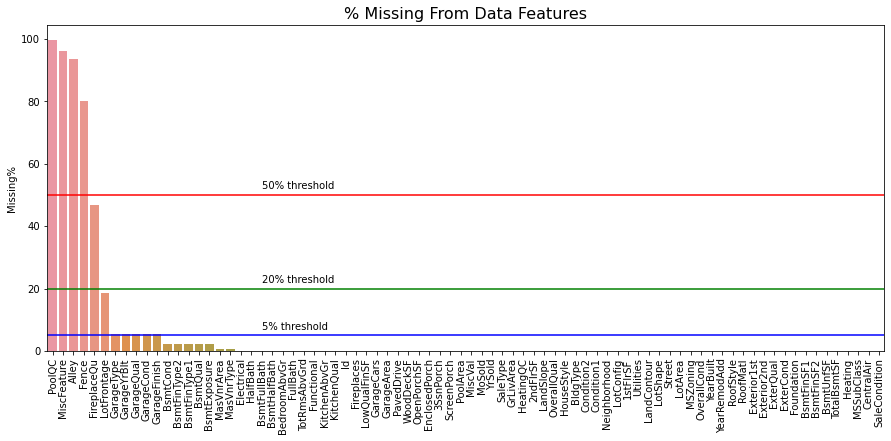

In [16]:
fig, ax = plt.subplots(figsize = (15,6))
sns.barplot(data = df_missing, x = df_missing.index, y = "Missing%", ax = ax)
plt.axhline(y = 50, color = "r")
plt.axhline(y = 20, color = "g")
plt.axhline(y = 5, color = "b")
plt.title("% Missing From Data Features", fontsize = 16)
plt.annotate("50% threshold", xy= (20, 52))
plt.annotate("20% threshold", xy= (20, 22))
plt.annotate("5% threshold", xy= (20, 7))
ax.tick_params(axis = "x", rotation = 90)
plt.show()

#### Features with more than 50% data point missing

Explore features with more than 50% missing data points to understand is that due to missing data points or due to the fact that this element does not exist in those houses and then the value should be 0 or NA (i.e., there is no Pool)

If that's because of missing data points, they should be completely eliminated from the dataset, otherwise they might be meaningful features that explain some of the outliers in the house prices

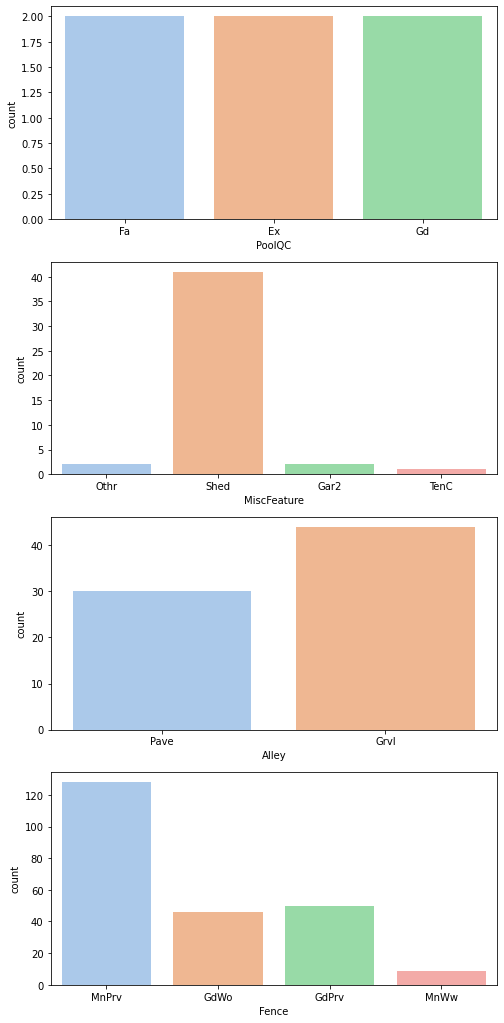

In [17]:
fig, ax = plt.subplots(4, figsize = (8, 18))

for x, i in enumerate(df_missing[df_missing["Missing%"] > 50].index):
    sns.countplot(data = x_train[[i]], x = x_train.loc[:, i], ax = ax[x], palette = "pastel")
    #ax[x].set_title(f"{i}", pad = 5)

So yes, it might be features that don't exist in some of the buildings, but we can't prove that this is a true assumption based on the given information so far. We can see whether it makes a significant difference in the price or not, and take a decision based on that.

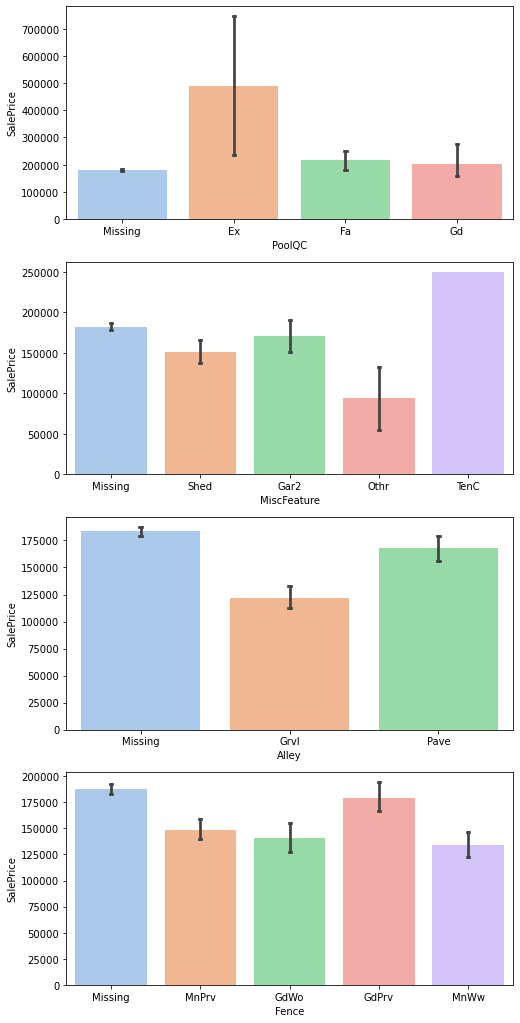

In [18]:
fig, ax = plt.subplots(4, figsize = (8, 18))

for x, i in enumerate(df_missing[df_missing["Missing%"] > 50].index):
    df[[i]] = df[[i]].fillna("Missing")
    sns.barplot(data = df, x = i, y = "SalePrice", ax = ax[x], palette = "pastel", ci = 95, capsize = 0.02)
    #ax[x].set_title(f"{i}", pad = 5)

It seems like this hypothesis is true in the "Alley" and "PoolQC" features. So we will keep those two, fill their NAs with a string that indicates the non-existence of them, and eliminate the other two features "Fence" and "MiscFeatures".

In [19]:
x_train[["Alley"]] = x_train[["Alley"]].fillna("No Alley")
x_train[["PoolQC"]] = x_train[["PoolQC"]].fillna("No Pool")

#Do the same for the test data
x_test[["Alley"]] = x_test[["Alley"]].fillna("No Alley")
x_test[["PoolQC"]] = x_test[["PoolQC"]].fillna("No Pool")

In [20]:
x_train = x_train.drop(["Fence", "MiscFeature", "Id"], axis = 1)

x_test = x_test.drop(["Fence", "MiscFeature", "Id"], axis = 1)

#### Features between 5% & 50% data point missing

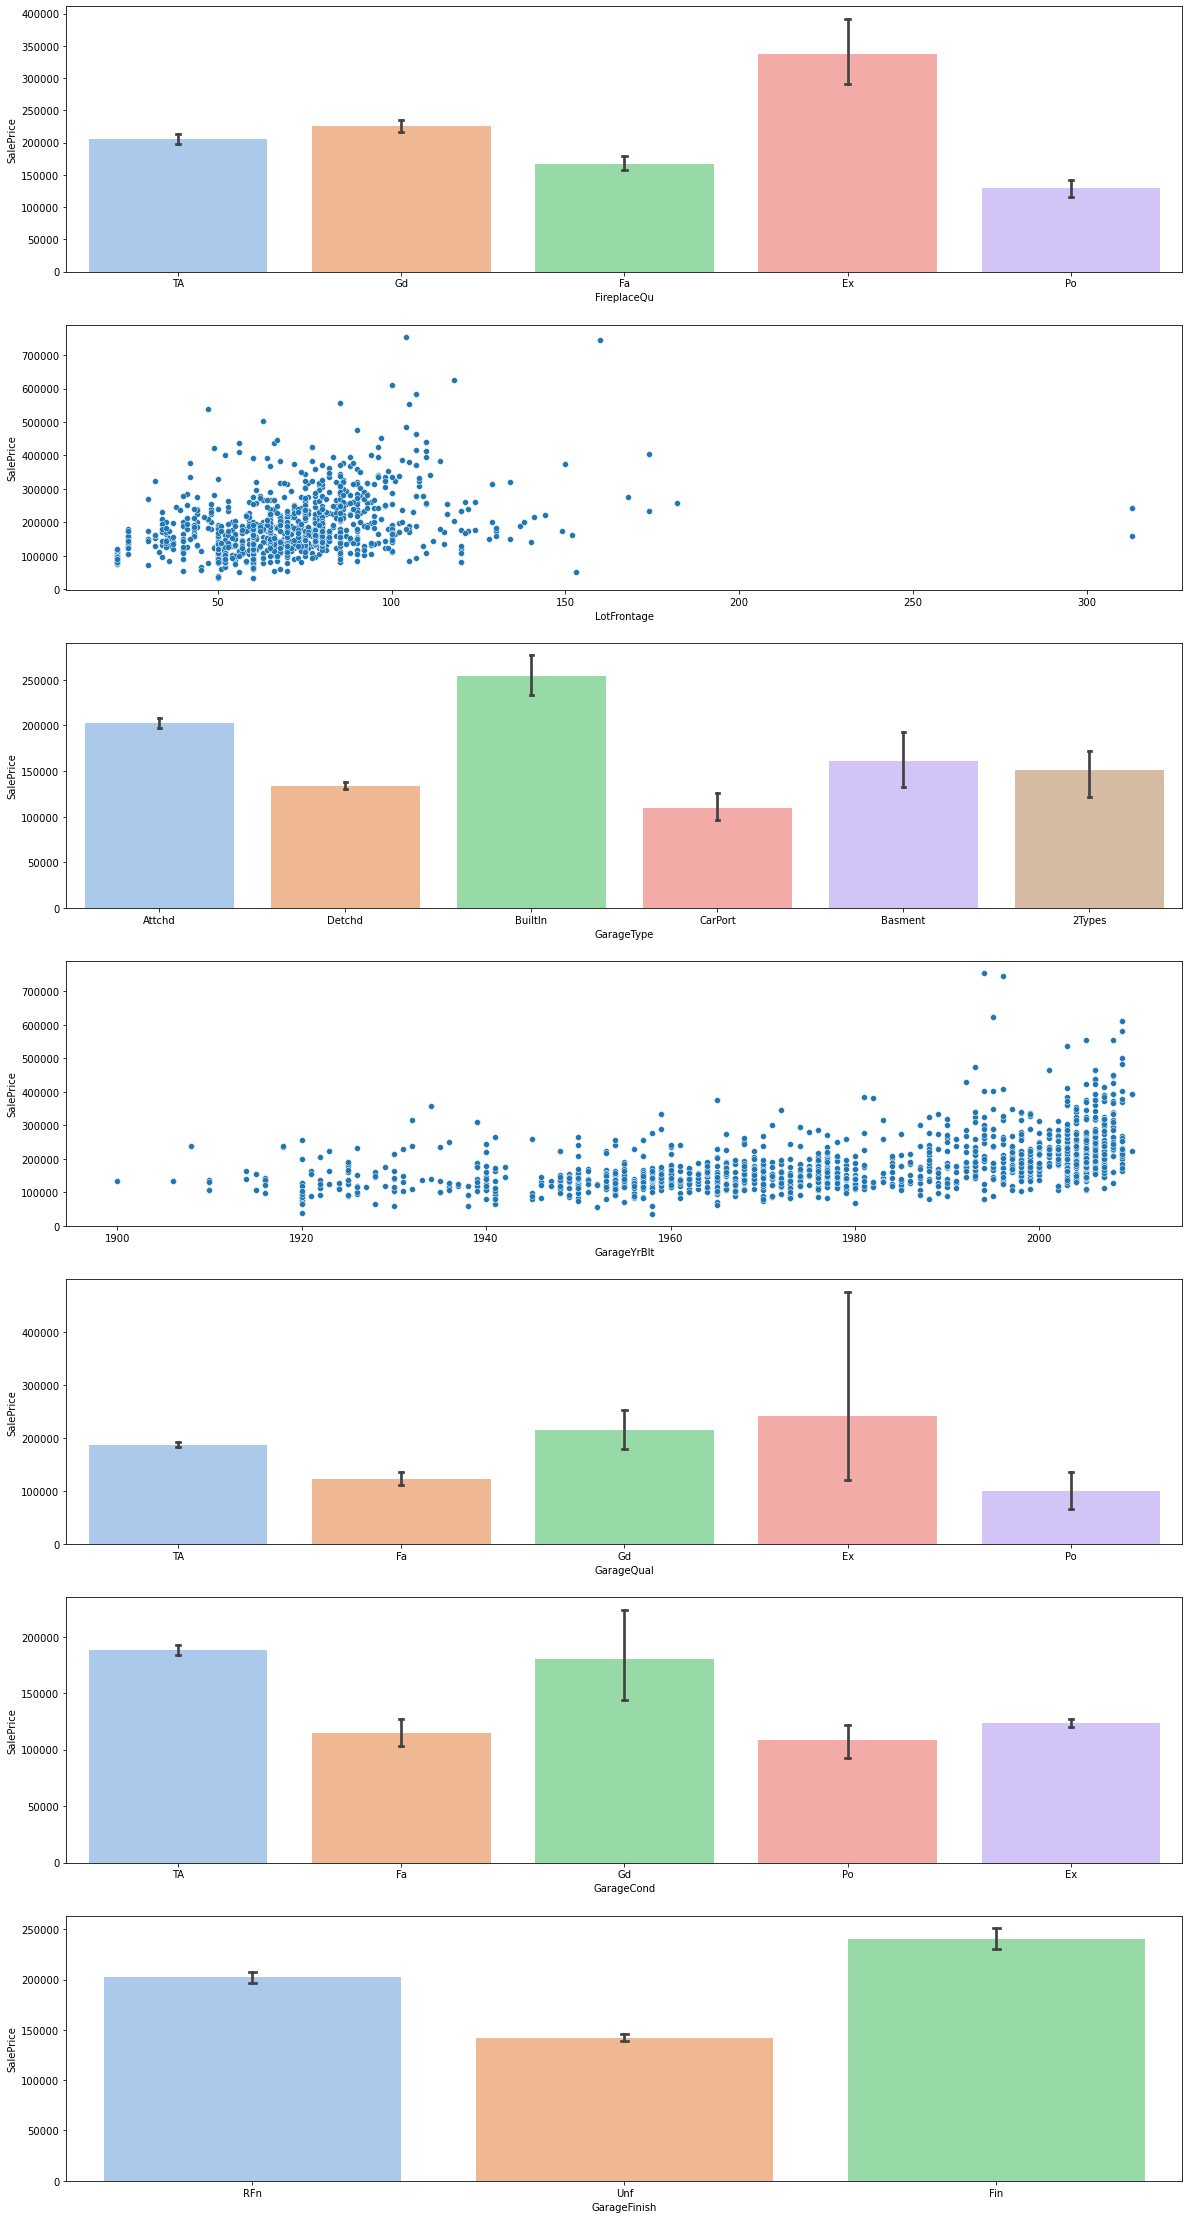

In [21]:
fig, ax = plt.subplots(7, figsize = (20, 40))

for x, i in enumerate(df_missing[(df_missing["Missing%"] < 50) & (df_missing["Missing%"] > 5)].index):
    if i in categorical:
        sns.barplot(data = df, x = i, y = "SalePrice", ax = ax[x], palette = "pastel", capsize = 0.02)
        #ax[x].set_title(f"{i}", pad = 20)
    elif i in numerical:
        sns.scatterplot(x = df.loc[:, i], y = df["SalePrice"], ax = ax[x])
        #ax[x].set_title(f"{i}", pad = 20)

OK, LotFrontage, FirePlaceQu seem to be important features that do worth it to fill their NAs. The other features are all related to Garage, if the same data instances are missing, that means there is no garage!

In [22]:
x_train["FireplaceQu"] = x_train["FireplaceQu"].fillna("No Fireplace")
x_train["LotFrontage"] = x_train["LotFrontage"].fillna(x_train["LotFrontage"].median())

x_test["FireplaceQu"] = x_test["FireplaceQu"].fillna("No Fireplace")
x_test["LotFrontage"] = x_test["LotFrontage"].fillna(x_train["LotFrontage"].median())

In [23]:
df[["GarageFinish", "GarageCond", "GarageQual", "GarageYrBlt", "GarageType"]].isnull().sum()

GarageFinish    81
GarageCond      81
GarageQual      81
GarageYrBlt     81
GarageType      81
dtype: int64

WOW! The same number of missing data points! Are they the same data instances?

In [24]:
df[["GarageFinish", "GarageCond", "GarageQual", "GarageYrBlt", "GarageType"]][df[["GarageFinish", "GarageCond", "GarageQual", "GarageYrBlt", "GarageType"]].isnull().any(axis = 1)]

,GarageFinish,GarageCond,GarageQual,GarageYrBlt,GarageType
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN


THEY ARE!! I also suspect that GarageQual and GarageCond should be the same, let's check...

In [25]:
df[["GarageFinish", "GarageCond", "GarageQual", "GarageYrBlt", "GarageType"]]

,GarageFinish,GarageCond,GarageQual,GarageYrBlt,GarageType
0,RFn,TA,TA,2003.0,Attchd
1,RFn,TA,TA,1976.0,Attchd
2,RFn,TA,TA,2001.0,Attchd
3,Unf,TA,TA,1998.0,Detchd
4,RFn,TA,TA,2000.0,Attchd
5,Unf,TA,TA,1993.0,Attchd
6,RFn,TA,TA,2004.0,Attchd
7,RFn,TA,TA,1973.0,Attchd
8,Unf,TA,Fa,1931.0,Detchd
9,RFn,TA,Gd,1939.0,Attchd


Almost the same, so I will remove GarageCond and fill the NAs in these variables

In [26]:
x_train[["GarageFinish", "GarageCond", "GarageQual", "GarageType"]] = x_train[["GarageFinish", "GarageCond", "GarageQual", "GarageType"]].fillna("No Garage")
x_test[["GarageFinish", "GarageCond", "GarageQual", "GarageType"]] = x_test[["GarageFinish", "GarageCond", "GarageQual", "GarageType"]].fillna("No Garage")

In [27]:
x_train["GarageYrBlt"] = x_train["GarageYrBlt"].fillna(0)
x_test["GarageYrBlt"] = x_test["GarageYrBlt"].fillna(0)

In [28]:
x_train = x_train.drop("GarageCond", axis = 1)
x_test = x_test.drop("GarageCond", axis = 1)

This really increased my curiosity, it might be the same with basement right?

In [29]:
df[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtCond"]][df[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtCond"]].isnull().any(axis = 1)]

,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtCond
17,NaN,NaN,NaN,0,NaN,0,0,0,NaN
39,NaN,NaN,NaN,0,NaN,0,0,0,NaN
90,NaN,NaN,NaN,0,NaN,0,0,0,NaN
102,NaN,NaN,NaN,0,NaN,0,0,0,NaN
156,NaN,NaN,NaN,0,NaN,0,0,0,NaN
182,NaN,NaN,NaN,0,NaN,0,0,0,NaN
259,NaN,NaN,NaN,0,NaN,0,0,0,NaN
332,Gd,No,GLQ,1124,NaN,479,1603,3206,TA
342,NaN,NaN,NaN,0,NaN,0,0,0,NaN
362,NaN,NaN,NaN,0,NaN,0,0,0,NaN


Yes!

In [30]:
x_train[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond"]] = x_train[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond"]].fillna("No Bsmt")
x_test[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond"]] = x_test[["BsmtQual", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond"]].fillna("No Bsmt")

In [31]:
x_train[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]] = x_train[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]].fillna(0)
x_test[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]] = x_test[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]].fillna(0)

Check what are the still-missing data?

In [32]:
x_train.isnull().sum().sort_values(ascending = False)

MasVnrType       6
MasVnrArea       6
Electrical       1
MSSubClass       0
HalfBath         0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
FullBath         0
FireplaceQu      0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
Fireplaces       0
GarageType       0
HeatingQC        0
3SsnPorch        0
SaleType         0
YrSold           0
MoSold           0
MiscVal          0
PoolQC           0
PoolArea         0
ScreenPorch      0
EnclosedPorch    0
GarageYrBlt      0
OpenPorchSF      0
WoodDeckSF       0
PavedDrive       0
GarageQual       0
GarageArea       0
GarageCars       0
GarageFinish     0
CentralAir       0
Heating          0
MSZoning         0
TotalBsmtSF      0
OverallQual      0
HouseStyle       0
BldgType         0
Condition2       0
Condition1       0
Neighborhood     0
LandSlope        0
LotConfig        0
Utilities        0
LandContour      0
LotShape    

In [33]:
x_train[["MasVnrArea"]] = x_train[["MasVnrArea"]].fillna(0)
x_train[["MasVnrType"]] = x_train[["MasVnrType"]].fillna("None")
x_train[["Electrical"]] = x_train[["Electrical"]].fillna(x_train[["Electrical"]].value_counts().idxmax()[0])

In [34]:
x_test[["MasVnrArea"]] = x_test[["MasVnrArea"]].fillna(0)
x_test[["MasVnrType"]] = x_test[["MasVnrType"]].fillna("None")
x_test[["Electrical"]] = x_test[["Electrical"]].fillna(x_train[["Electrical"]].value_counts().idxmax()[0])

### Correlations

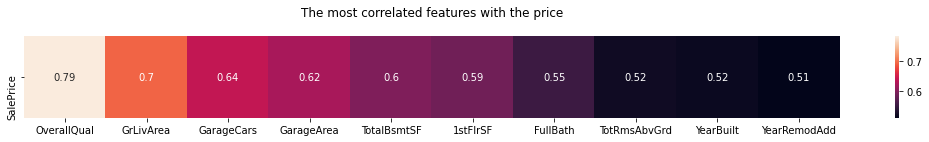

In [35]:
fig, ax = plt.subplots(figsize = (20,1.5))
sns.heatmap(pd.concat([x_train,y_train], axis = 1).corr()[["SalePrice"]].sort_values(by = "SalePrice", ascending = False).nlargest(11, "SalePrice").T.iloc[:,1:], annot = True, square = True, ax = ax)
ax.set_title("The most correlated features with the price", pad = 20)
plt.show()

In [36]:
correlated_features = pd.concat([x_train,y_train], axis = 1).corr()[["SalePrice"]].sort_values(by = "SalePrice", ascending = False).nlargest(5, "SalePrice").index

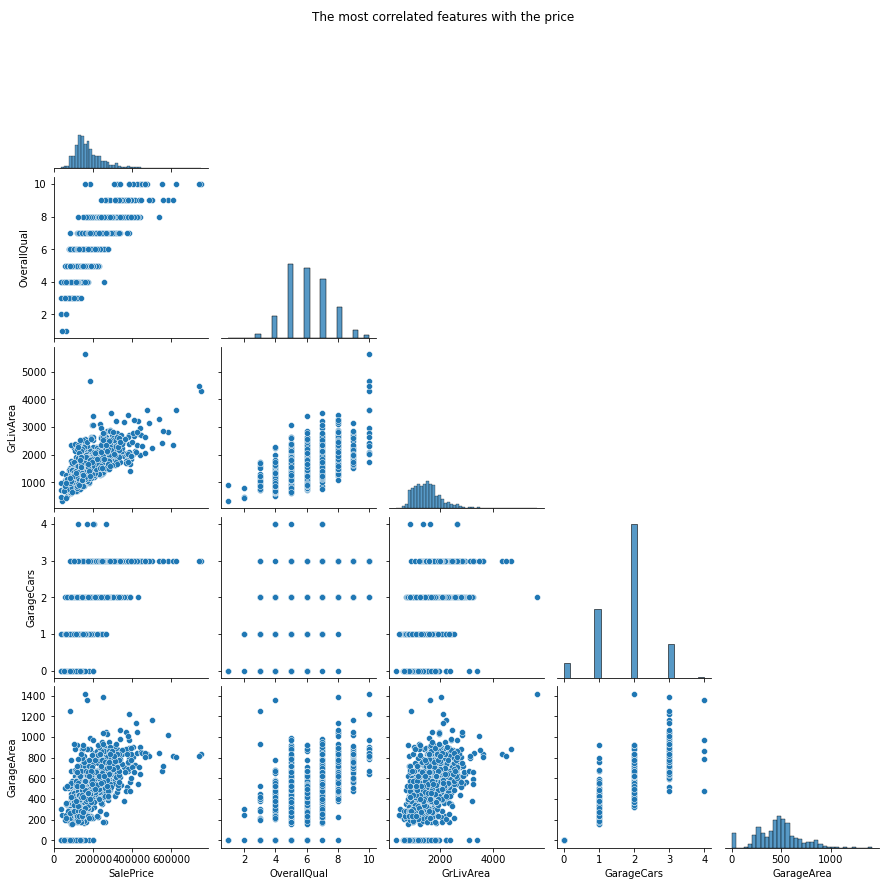

In [37]:
sns.pairplot(df[correlated_features], corner = True, palette = "pastel")
plt.suptitle("The most correlated features with the price")
plt.show()

In [38]:
correlated_features_2 = pd.concat([x_train,y_train], axis = 1).corr()[["SalePrice"]].sort_values(by = "SalePrice", ascending = False).nlargest(11, "SalePrice").iloc[1:, :].index

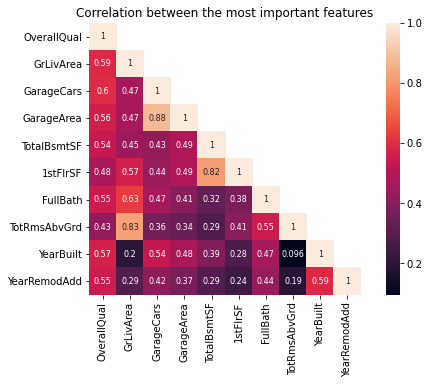

In [39]:
corr = df[correlated_features_2].corr()
fig, ax = plt.subplots(figsize = (9,5))
msk = np.triu(corr, k = 1)
sns.heatmap(corr, annot = True, annot_kws={"size":8}, mask = msk, ax = ax, square = True)
plt.title("Correlation between the most important features")
plt.show()

In [40]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(x_train_num.values, i) for i in range(x_train_num.shape[1])]
#vif["features"] = x_train_num.columns

In [41]:
#vif.sort_values(by = "VIF Factor", ascending = False)

These couples need to be investigated and are important to the prediction at the same time: "GrLivArea & TotRMsAbvGrd", "TotalBsmtSF & 1stFlrSF", and "GarageArea & GarageCars"

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

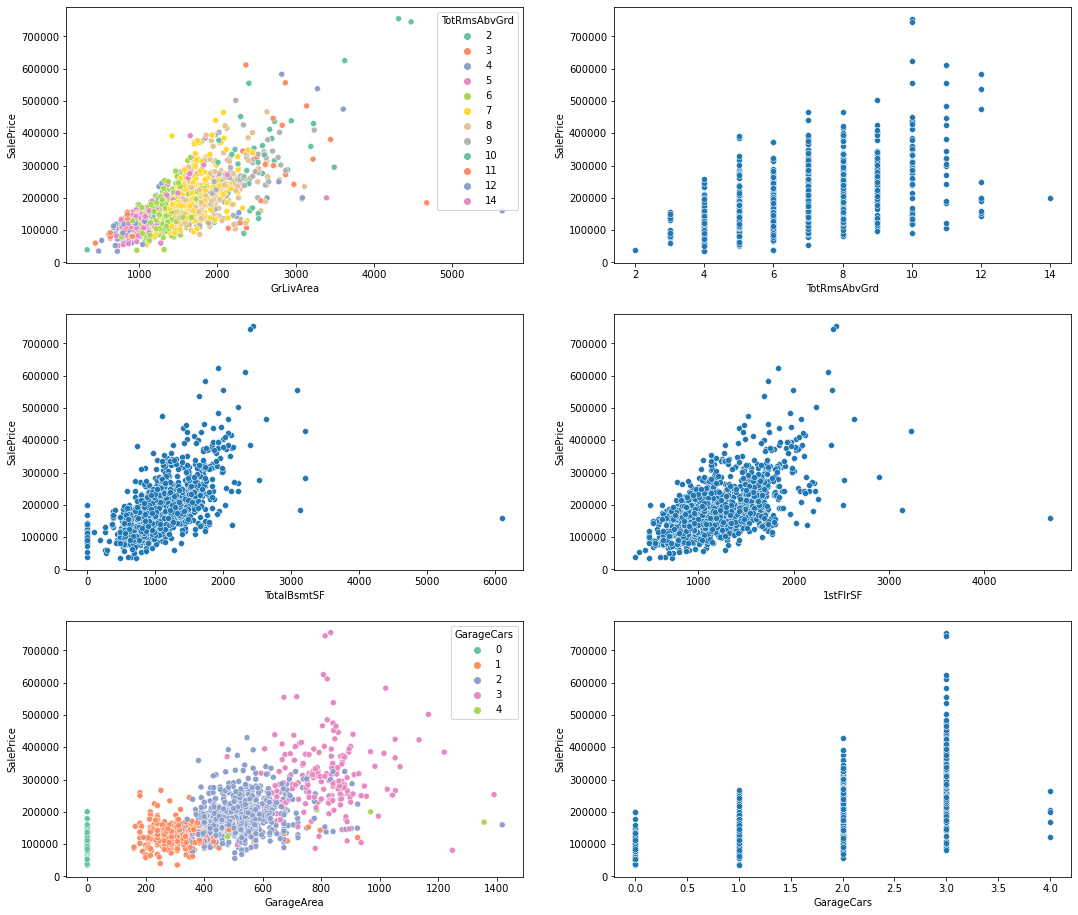

In [42]:
fig, ax = plt.subplots(3, 2, figsize = (18,16))
sns.scatterplot(data = df, x = "GrLivArea", y = "SalePrice", ax = ax[0,0], hue = "TotRmsAbvGrd", palette = "Set2")
sns.scatterplot(data = df, x = "TotRmsAbvGrd", y = "SalePrice", ax = ax[0,1])
sns.scatterplot(data = df, x = "TotalBsmtSF", y = "SalePrice", ax = ax[1,0])
sns.scatterplot(data = df, x = "1stFlrSF", y = "SalePrice", ax = ax[1,1])
sns.scatterplot(data = df, x = "GarageArea", y = "SalePrice", ax = ax[2,0], hue = "GarageCars", palette = "Set2")
sns.scatterplot(data = df, x = "GarageCars", y = "SalePrice", ax = ax[2,1])

In [43]:
corr_all = x_train.corr().unstack().sort_values(ascending = False, kind="quicksort").to_frame()

In [44]:
highest_corr = corr_all[(corr_all[0] < 1) & (corr_all[0] > 0.6)].drop_duplicates()

In [45]:
highest_corr

,,0
GarageArea,GarageCars,0.882550
1stFlrSF,TotalBsmtSF,0.827382
GrLivArea,TotRmsAbvGrd,0.820718
2ndFlrSF,GrLivArea,0.687505
BedroomAbvGr,TotRmsAbvGrd,0.678937
BsmtFullBath,BsmtFinSF1,0.648970
TotRmsAbvGrd,2ndFlrSF,0.622290
GrLivArea,FullBath,0.617812
GarageYrBlt,GarageCars,0.603729


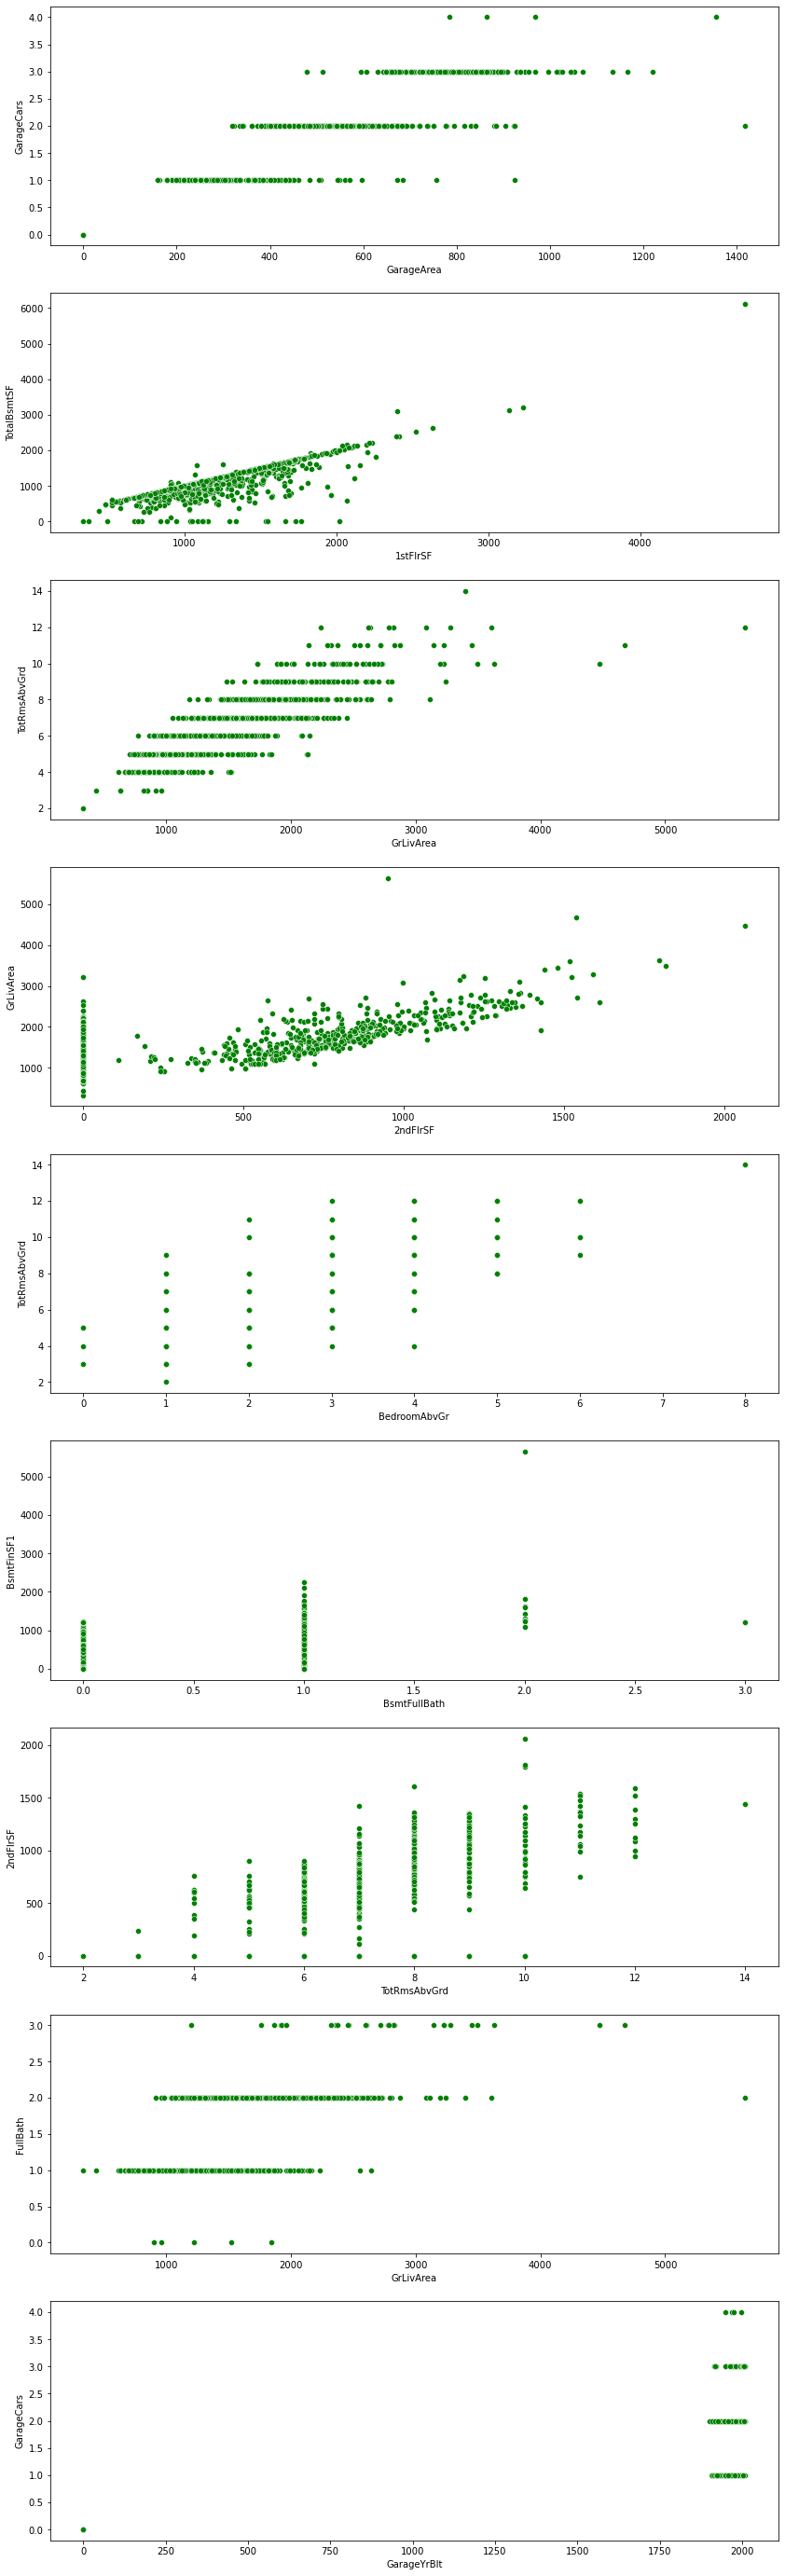

In [46]:
fig, ax = plt.subplots(9, figsize = (14,50))
for i, m_index in enumerate(highest_corr.index):
    sns.scatterplot(data = x_train, x = m_index[0], y = m_index[1], ax = ax[i], color = "green")

Probably we will remove "TotalBSMTSF", "GarageArea" and "TotRmsAbvGrd"

In [47]:
#x_train = x_train.drop(["TotalBsmtSF", "GarageArea", "TotRmsAbvGrd"], axis = 1)
#x_train = x_train.drop(vif.iloc[:12,:].features.to_list(), axis = 1)

In [48]:
#vif.iloc[:12,:].features.to_list()

In [49]:
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,70.0,8400,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,No Fireplace,Attchd,1957.0,RFn,1,294,TA,Y,250,0,0,0,0,0,No Pool,0,6,2010,WD,Normal
1066,60,RL,59.0,7837,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,Y,0,40,0,0,0,0,No Pool,0,5,2009,WD,Normal
638,30,RL,67.0,8777,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,No Fireplace,No Garage,0.0,No Garage,0,0,No Garage,P,328,0,164,0,0,0,No Pool,0,5,2008,WD,Normal
799,50,RL,60.0,7200,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,Y,0,0,264,0,0,0,No Pool,0,6,2007,WD,Normal
380,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,Y,0,0,242,0,0,0,No Pool,0,5,2010,WD,Normal


In [50]:
#x_test = x_test.drop(["TotalBsmtSF", "GarageArea", "TotRmsAbvGrd"], axis = 1)

## Statistical Distributions

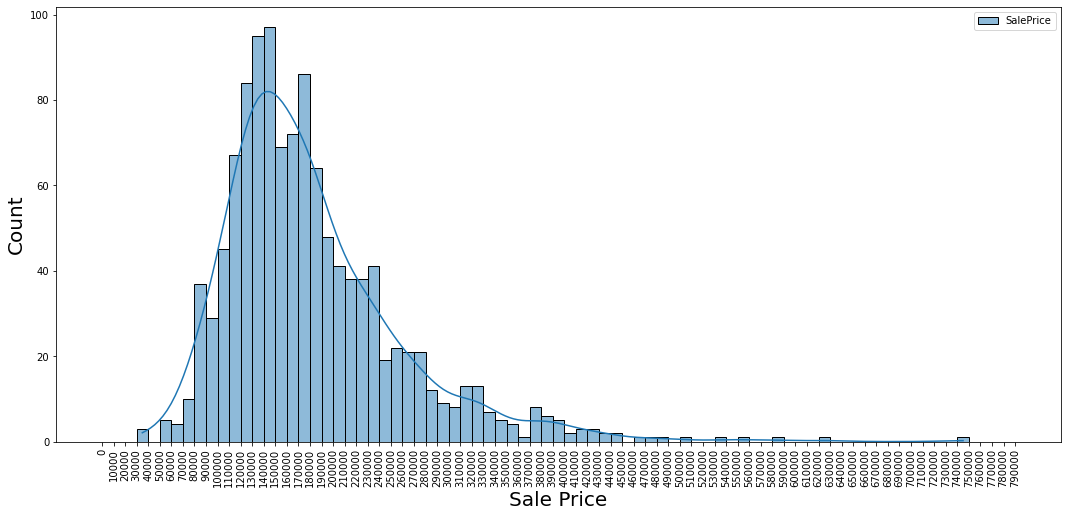

In [51]:
fig, ax = plt.subplots(figsize = (18,8))
ax = sns.histplot(y_train, kde = True, bins = np.arange(0, 800000, 10000), color = "purple")
ax.set_xticks(np.arange(0, 800000, 10000));
ax.tick_params(axis = "x", rotation = 90)
ax.set_xlabel("Sale Price", fontsize = 20);
ax.set_ylabel("Count", fontsize = 20);

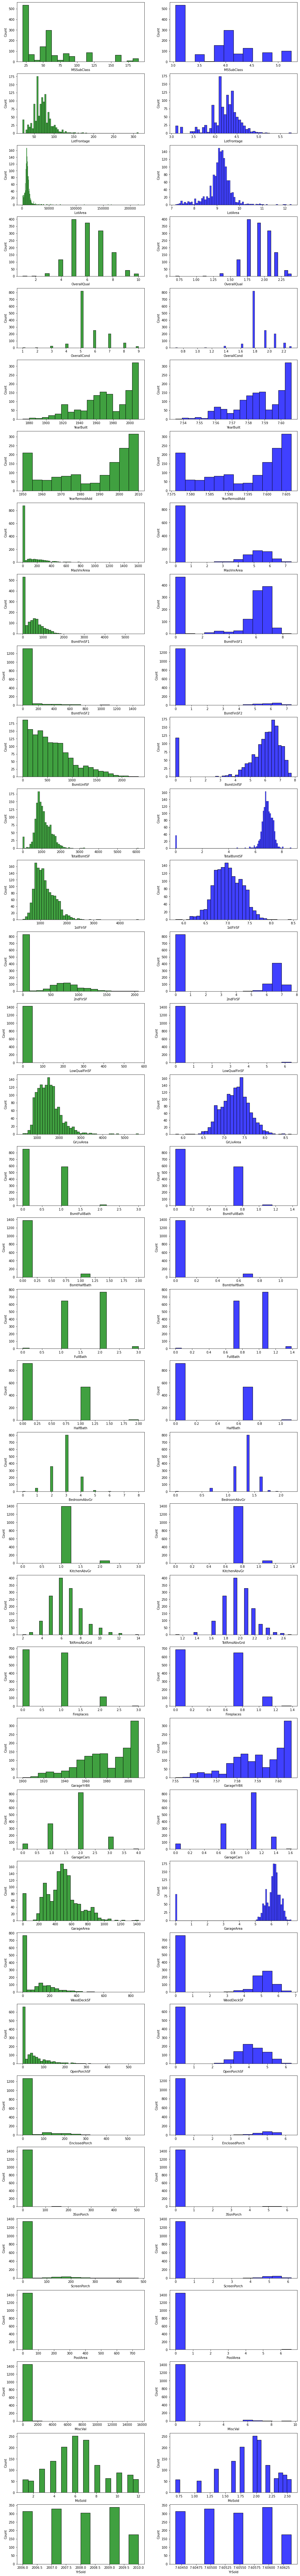

In [52]:
fig, ax = plt.subplots(len(numerical[1:]),2, figsize = (16, 150))

for i, ft in enumerate(numerical[1:]):
    sns.histplot(df[ft], ax = ax[i,0], color = "green")
    sns.histplot(np.log(df[ft]+1), ax = ax[i,1], color = "blue")

## Data Preprocessing

In [53]:
pt = PowerTransformer()
pt.fit(y_train)
y_train_final = pt.transform(y_train)

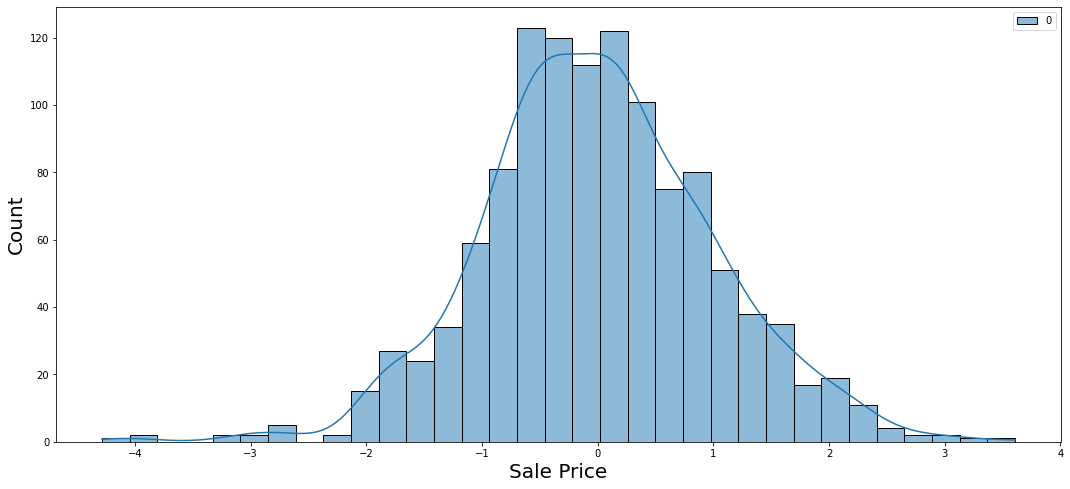

In [54]:
fig, ax = plt.subplots(figsize = (18,8))
ax = sns.histplot(y_train_final, kde = True, stat = "count", color = "purple")
ax.set_xlabel("Sale Price", fontsize = 20);
ax.set_ylabel("Count", fontsize = 20);

In [55]:
pt2 = PowerTransformer()
x_train[["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]] = pt2.fit_transform(x_train[["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]])

In [56]:
x_test[["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]] = pt2.transform(x_test[["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]])

In [57]:
y_test_final = pt.transform(y_test)

In [58]:
x_test = x_test.loc[:, x_train.columns]

In [59]:
x_test.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [60]:
#For training set
x_train_num_final = x_train.select_dtypes(["int64", "float64"])
x_train_cat_final = x_train.select_dtypes("object")

#For test set
x_test_num = x_test.select_dtypes(["int64", "float64"])
x_test_cat = x_test.select_dtypes("object")

In [61]:
x_train_num_final.shape, x_train_cat_final.shape, x_train.shape

((1168, 36), (1168, 40), (1168, 76))

In [62]:
x_test_num.shape, x_test_cat.shape, x_train.shape

((292, 36), (292, 40), (1168, 76))

In [63]:
scaler = RobustScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")

In [64]:
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,0.080687,-0.167702,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,0.529886,0,0,-0.291520,1,0,1,0,3,1,TA,5,Typ,0,No Fireplace,Attchd,1957.0,RFn,1,294,TA,Y,250,0,0,0,0,0,No Pool,0,6,2010,WD,Normal
1066,60,RL,-0.460727,-0.301943,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,-1.041008,772,0,0.251690,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,Y,0,40,0,0,0,0,No Pool,0,5,2009,WD,Normal
638,30,RL,-0.061477,-0.082737,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,-1.052961,0,0,-1.818934,0,0,1,0,2,1,TA,4,Typ,0,No Fireplace,No Garage,0.0,No Garage,0,0,No Garage,P,328,0,164,0,0,0,No Pool,0,5,2008,WD,Normal
799,50,RL,-0.409080,-0.465947,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,-0.390628,787,0,0.610586,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,Y,0,0,264,0,0,0,No Pool,0,6,2007,WD,Normal
380,50,RL,-0.951667,-1.170923,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,-0.248925,665,0,0.475341,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,Y,0,0,242,0,0,0,No Pool,0,5,2010,WD,Normal


In [65]:
x_train_enc = pd.DataFrame(ohe.fit_transform(x_train_cat_final), columns = ohe.get_feature_names())
#x_train_sc = pd.DataFrame(scaler.fit_transform(x_train_num), columns = x_train_num.columns)

In [66]:
x_test_enc = pd.DataFrame(ohe.transform(x_test_cat), columns = ohe.get_feature_names())

In [67]:
x_train_enc.shape

(1168, 248)

In [68]:
x_test_enc.shape

(292, 248)

In [69]:
x_train_enc = x_train_enc.drop(["x22_No Bsmt", "x23_No Bsmt", "x24_No Bsmt", "x25_No Bsmt", "x34_No Garage", "x35_No Garage"],
                              axis = 1)

In [70]:
x_train_enc.head()

,x0_C (all),x0_FV,x0_RH,x0_RL,x0_RM,x1_Grvl,x1_Pave,x2_Grvl,x2_No Alley,x2_Pave,x3_IR1,x3_IR2,x3_IR3,x3_Reg,x4_Bnk,x4_HLS,x4_Low,x4_Lvl,x5_AllPub,x5_NoSeWa,x6_Corner,x6_CulDSac,x6_FR2,x6_FR3,x6_Inside,x7_Gtl,x7_Mod,x7_Sev,x8_Blmngtn,x8_Blueste,x8_BrDale,x8_BrkSide,x8_ClearCr,x8_CollgCr,x8_Crawfor,x8_Edwards,x8_Gilbert,x8_IDOTRR,x8_MeadowV,x8_Mitchel,x8_NAmes,x8_NPkVill,x8_NWAmes,x8_NoRidge,x8_NridgHt,x8_OldTown,x8_SWISU,x8_Sawyer,x8_SawyerW,x8_Somerst,x8_StoneBr,x8_Timber,x8_Veenker,x9_Artery,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNe,x9_RRNn,x10_Artery,x10_Feedr,x10_Norm,x10_PosA,x10_PosN,x10_RRAe,x10_RRAn,x10_RRNn,x11_1Fam,x11_2fmCon,x11_Duplex,x11_Twnhs,x11_TwnhsE,x12_1.5Fin,x12_1.5Unf,x12_1Story,x12_2.5Fin,x12_2.5Unf,x12_2Story,x12_SFoyer,x12_SLvl,x13_Flat,x13_Gable,x13_Gambrel,x13_Hip,x13_Mansard,x13_Shed,x14_ClyTile,x14_CompShg,x14_Metal,x14_Roll,x14_Tar&Grv,x14_WdShake,x14_WdShngl,x15_AsbShng,x15_AsphShn,x15_BrkComm,x15_BrkFace,x15_CBlock,x15_CemntBd,x15_HdBoard,x15_ImStucc,x15_MetalSd,x15_Plywood,x15_Stone,x15_Stucco,x15_VinylSd,x15_Wd Sdng,x15_WdShing,x16_AsbShng,x16_AsphShn,x16_Brk Cmn,x16_BrkFace,x16_CBlock,x16_CmentBd,x16_HdBoard,x16_ImStucc,x16_MetalSd,x16_Other,x16_Plywood,x16_Stone,x16_Stucco,x16_VinylSd,x16_Wd Sdng,x16_Wd Shng,x17_BrkCmn,x17_BrkFace,x17_None,x17_Stone,x18_Ex,x18_Fa,x18_Gd,x18_TA,x19_Ex,x19_Fa,x19_Gd,x19_Po,x19_TA,x20_BrkTil,x20_CBlock,x20_PConc,x20_Slab,x20_Stone,x20_Wood,x21_Ex,x21_Fa,x21_Gd,x21_No Bsmt,x21_TA,x22_Fa,x22_Gd,x22_Po,x22_TA,x23_Av,x23_Gd,x23_Mn,x23_No,x24_ALQ,x24_BLQ,x24_GLQ,x24_LwQ,x24_Rec,x24_Unf,x25_ALQ,x25_BLQ,x25_GLQ,x25_LwQ,x25_Rec,x25_Unf,x26_Floor,x26_GasA,x26_GasW,x26_Grav,x26_OthW,x26_Wall,x27_Ex,x27_Fa,x27_Gd,x27_Po,x27_TA,x28_N,x28_Y,x29_FuseA,x29_FuseF,x29_FuseP,x29_SBrkr,x30_Ex,x30_Fa,x30_Gd,x30_TA,x31_Maj1,x31_Maj2,x31_Min1,x31_Min2,x31_Mod,x31_Sev,x31_Typ,x32_Ex,x32_Fa,x32_Gd,x32_No Fireplace,x32_Po,x32_TA,x33_2Types,x33_Attchd,x33_Basment,x33_BuiltIn,x33_CarPort,x33_Detchd,x33_No Garage,x34_Fin,x34_RFn,x34_Unf,x35_Ex,x35_Fa,x35_Gd,x35_Po,x35_TA,x36_N,x36_P,x36_Y,x37_Ex,x37_Fa,x37_Gd,x37_No Pool,x38_COD,x38_CWD,x38_Con,x38_ConLD,x38_ConLI,x38_ConLw,x38_New,x38_Oth,x38_WD,x39_Abnorml,x39_AdjLand,x39_Alloca,x39_Family,x39_Normal,x39_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [71]:
x_train_num_final.reset_index(drop = True, inplace = True)
x_train_enc.reset_index(drop = True, inplace = True)

In [72]:
x_test_num.reset_index(drop = True, inplace = True)
x_test_enc.reset_index(drop = True, inplace = True)

In [73]:
x_train_final = pd.concat([x_train_num_final, x_train_enc], axis = 1)

In [74]:
x_train_num_final.shape, x_train_enc.shape

((1168, 36), (1168, 242))

In [75]:
x_test_num.shape, x_test_enc.shape

((292, 36), (292, 248))

In [76]:
x_train_sc = pd.DataFrame(scaler.fit_transform(x_train_final), columns = x_train_final.columns)

In [77]:
x_test_final = pd.concat([x_test_num, x_test_enc], axis = 1).loc[:, x_train_final.columns]

In [78]:
x_test_sc = pd.DataFrame(scaler.transform(x_test_final), columns = x_test_final.columns)

In [79]:
x_train_sc.shape

(1168, 278)

In [80]:
x_train_sc.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,x0_C (all),x0_FV,x0_RH,x0_RL,x0_RM,x1_Grvl,x1_Pave,x2_Grvl,x2_No Alley,x2_Pave,x3_IR1,x3_IR2,x3_IR3,x3_Reg,x4_Bnk,x4_HLS,x4_Low,x4_Lvl,x5_AllPub,x5_NoSeWa,x6_Corner,x6_CulDSac,x6_FR2,x6_FR3,x6_Inside,x7_Gtl,x7_Mod,x7_Sev,x8_Blmngtn,x8_Blueste,x8_BrDale,x8_BrkSide,x8_ClearCr,x8_CollgCr,x8_Crawfor,x8_Edwards,x8_Gilbert,x8_IDOTRR,x8_MeadowV,x8_Mitchel,x8_NAmes,x8_NPkVill,x8_NWAmes,x8_NoRidge,x8_NridgHt,x8_OldTown,x8_SWISU,x8_Sawyer,x8_SawyerW,x8_Somerst,x8_StoneBr,x8_Timber,x8_Veenker,x9_Artery,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNe,x9_RRNn,x10_Artery,x10_Feedr,x10_Norm,x10_PosA,x10_PosN,x10_RRAe,x10_RRAn,x10_RRNn,x11_1Fam,x11_2fmCon,x11_Duplex,x11_Twnhs,x11_TwnhsE,x12_1.5Fin,x12_1.5Unf,x12_1Story,x12_2.5Fin,x12_2.5Unf,x12_2Story,x12_SFoyer,x12_SLvl,x13_Flat,x13_Gable,x13_Gambrel,x13_Hip,x13_Mansard,x13_Shed,x14_ClyTile,x14_CompShg,x14_Metal,x14_Roll,x14_Tar&Grv,x14_WdShake,x14_WdShngl,x15_AsbShng,x15_AsphShn,x15_BrkComm,x15_BrkFace,x15_CBlock,x15_CemntBd,x15_HdBoard,x15_ImStucc,x15_MetalSd,x15_Plywood,x15_Stone,x15_Stucco,x15_VinylSd,x15_Wd Sdng,x15_WdShing,x16_AsbShng,x16_AsphShn,x16_Brk Cmn,x16_BrkFace,x16_CBlock,x16_CmentBd,x16_HdBoard,x16_ImStucc,x16_MetalSd,x16_Other,x16_Plywood,x16_Stone,x16_Stucco,x16_VinylSd,x16_Wd Sdng,x16_Wd Shng,x17_BrkCmn,x17_BrkFace,x17_None,x17_Stone,x18_Ex,x18_Fa,x18_Gd,x18_TA,x19_Ex,x19_Fa,x19_Gd,x19_Po,x19_TA,x20_BrkTil,x20_CBlock,x20_PConc,x20_Slab,x20_Stone,x20_Wood,x21_Ex,x21_Fa,x21_Gd,x21_No Bsmt,x21_TA,x22_Fa,x22_Gd,x22_Po,x22_TA,x23_Av,x23_Gd,x23_Mn,x23_No,x24_ALQ,x24_BLQ,x24_GLQ,x24_LwQ,x24_Rec,x24_Unf,x25_ALQ,x25_BLQ,x25_GLQ,x25_LwQ,x25_Rec,x25_Unf,x26_Floor,x26_GasA,x26_GasW,x26_Grav,x26_OthW,x26_Wall,x27_Ex,x27_Fa,x27_Gd,x27_Po,x27_TA,x28_N,x28_Y,x29_FuseA,x29_FuseF,x29_FuseP,x29_SBrkr,x30_Ex,x30_Fa,x30_Gd,x30_TA,x31_Maj1,x31_Maj2,x31_Min1,x31_Min2,x31_Mod,x31_Sev,x31_Typ,x32_Ex,x32_Fa,x32_Gd,x32_No Fireplace,x32_Po,x32_TA,x33_2Types,x33_Attchd,x33_Basment,x33_BuiltIn,x33_CarPort,x33_Detchd,x33_No Garage,x34_Fin,x34_RFn,x34_Unf,x35_Ex,x35_Fa,x35_Gd,x35_Po,x35_TA,x36_N,x36_P,x36_Y,x37_Ex,x37_Fa,x37_Gd,x37_No Pool,x38_COD,x38_CWD,x38_Con,x38_ConLD,x38_ConLI,x38_ConLw,x38_New,x38_Oth,x38_WD,x39_Abnorml,x39_AdjLand,x39_Alloca,x39_Family,x39_Normal,x39_Partial
0,-0.6,0.000000,-0.308260,-0.5,1.0,-0.312500,-0.973684,0.000000,0.745492,0.0,-0.149724,0.628912,0.401792,0.000000,0.0,-0.255430,1.0,0.0,-1.0,0.0,0.0,0.0,-0.5,-1.0,-0.488372,-1.0,-0.800000,1.488095,-0.364865,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,-0.604872,-0.468370,0.0,2.0,0.437500,0.000000,0.000000,-0.533287,0.0,0.542748,-0.394436,-0.698854,1.060440,0.0,0.143955,0.0,0.0,0.0,1.0,0.

In [81]:
vif2 = pd.DataFrame()

vif2["VIF"] = [variance_inflation_factor(x_train_sc.values, i) for i in range(x_train_sc.shape[1])]
vif2["features"] = x_train_sc.columns

divide by zero encountered in double_scalars


In [82]:
vif2.sort_values(by = "VIF", ascending = False)

,VIF,features
139,inf,x15_ImStucc
184,inf,x21_Gd
190,inf,x22_TA
189,inf,x22_Po
188,inf,x22_Gd
187,inf,x22_Fa
186,inf,x21_TA
185,inf,x21_No Bsmt
183,inf,x21_Fa
175,inf,x19_TA


In [83]:
x_train_sc_final = x_train_sc.drop(vif2[vif2.VIF > 50].features, axis = 1)

In [84]:
x_train_sc_final.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold
0,0.000000,-0.308260,-0.5,1.0,-0.312500,-0.973684,0.000000,0.401792,0.000000,0.0,-0.255430,1.0,0.0,-1.0,0.0,0.0,0.0,-0.5,-1.0,-1.0,-0.800000,1.488095,-0.364865,0.0,0.0,0.0,0.0,0.000000,1.0
1,-0.604872,-0.468370,0.0,2.0,0.437500,0.000000,0.000000,-0.698854,1.060440,0.0,0.143955,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,-0.434043,0.000000,0.175676,0.0,0.0,0.0,0.0,-0.333333,0.5
2,-0.158826,-0.206922,-0.5,2.0,-1.291667,-1.157895,0.000000,-0.707229,0.000000,0.0,-1.378432,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-2.0,-2.051064,1.952381,-0.364865,164.0,0.0,0.0,0.0,-0.333333,0.0
3,-0.547171,-0.663976,-0.5,2.0,-0.729167,-1.157895,1.518072,-0.243166,1.081044,0.0,0.407826,1.0,0.0,-1.0,1.0,0.0,0.0,0.5,1.0,-1.0,-1.029787,0.000000,-0.364865,264.0,0.0,0.0,0.0,0.000000,-0.5
4,-1.153354,-1.504803,-0.5,1.0,-1.000000,-1.157895,0.000000,-0.143882,0.913462,0.0,0.308389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.740426,0.000000,-0.364865,242.0,0.0,0.0,0.0,-0.333333,1.0


In [85]:
x_train_sc_final.shape

(1168, 29)

In [86]:
x_test_sc_final = x_test_sc.drop(vif2[vif2.VIF > 50].features, axis = 1)

In [87]:
x_test_sc_final.shape

(292, 29)

# Machine Learning Models

## 1 - Linear Regression

In [88]:
lm = LinearRegression()

In [89]:
#Calculate cross-validated model accuracy for the comparison purposes
lm_r2_cv = cross_val_score(lm, x_train_sc, y_train_final, cv = 10)
lm_rmse_cv = np.abs(cross_val_score(lm, x_train_sc, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [90]:
#Calculate cross-validated model accuracy for the comparison purposes
lm_r2_cv_w_features_eliminated = cross_val_score(lm, x_train_sc_final, y_train_final, cv = 10)
lm_rmse_cv_w_features_eliminated = np.abs(cross_val_score(lm, x_train_sc_final, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [91]:
print("The mean R-Squared of Linear Regression model is: {0:.2f}\nThe mean RMSE of Linear Regression model is: {1:.2f}".format(lm_r2_cv.mean(), lm_rmse_cv.mean()))

The mean R-Squared of Linear Regression model is: 0.84
The mean RMSE of Linear Regression model is: 39794.93


In [92]:
print("The mean R-Squared of Linear Regression model with feature elimination is: {0:.2f}\nThe mean RMSE of Linear Regression model with feature elimination is: {1:.2f}".format(lm_r2_cv_w_features_eliminated.mean(), lm_rmse_cv_w_features_eliminated.mean()))

The mean R-Squared of Linear Regression model with feature elimination is: 0.86
The mean RMSE of Linear Regression model with feature elimination is: 34749.85


In [93]:
#Fit the model to the entire training data with features eliminated
lm.fit(x_train_sc_final,y_train_final)

LinearRegression()

In [94]:
#Fit another version of the model to the entire training data without features elimination
lm2 = LinearRegression()
lm2.fit(x_train_sc, y_train_final)

LinearRegression()

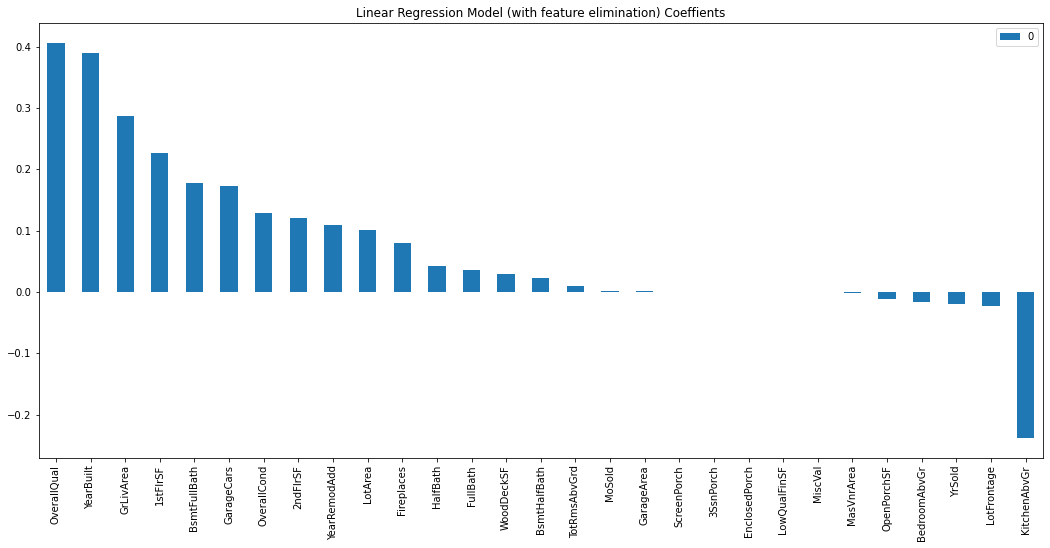

In [95]:
#Plot the linear regression model coeffients in descending order to understand the model feature importance
pd.DataFrame(lm.coef_, columns = x_train_sc_final.columns).T.sort_values(by = 0, ascending = False).plot(kind = "bar", figsize = (18,8), title = "Linear Regression Model (with feature elimination) Coeffients")
plt.show()

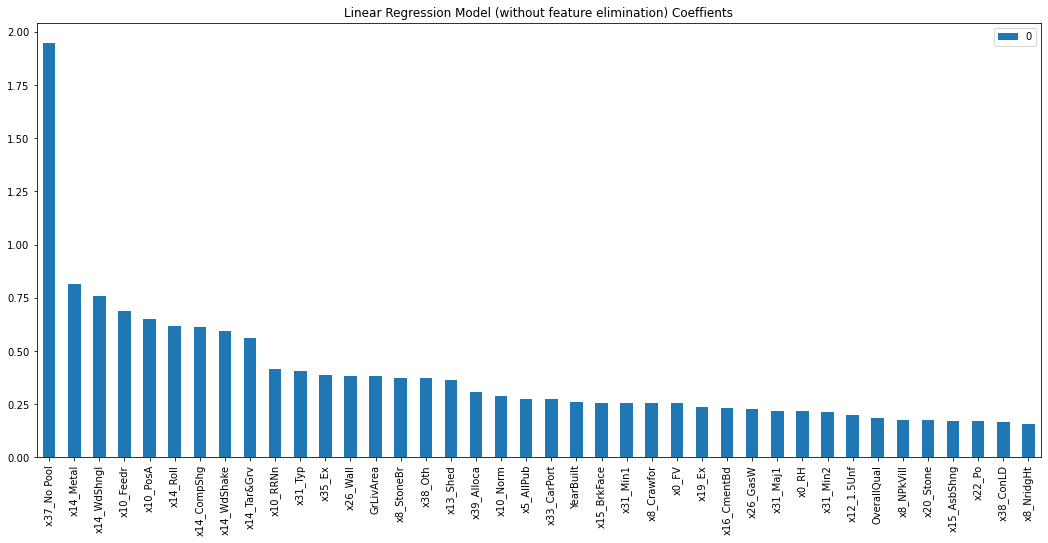

In [96]:
#Plot the linear regression model coeffients in descending order to understand the model feature importance
pd.DataFrame(lm2.coef_, columns = x_train_sc.columns).T.sort_values(by = 0, ascending = False)[:40].plot(kind = "bar", figsize = (18,8), title = "Linear Regression Model (without feature elimination) Coeffients")
plt.show()

## 2- Ridge Regression

In [97]:
alphas = np.arange(0,50,0.1)
cvs = []
for alpha in alphas:
    rm = Ridge(alpha = alpha)
    cvs.append(cross_val_score(rm, x_train_sc_final,y_train_final).mean())    

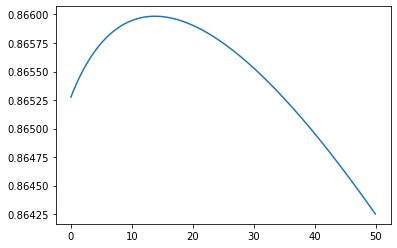

In [98]:
plt.plot(alphas, cvs)

In [99]:
rm = Ridge(alpha = 13)

In [100]:
rm.fit(x_train_sc_final,y_train_final)

Ridge(alpha=13)

In [101]:
rm_r2_cv = cross_val_score(rm, x_train_sc, y_train_final, scoring = "r2", cv = 10)
rm_rmse_cv = np.abs(cross_val_score(rm, x_train_sc, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [102]:
rm_r2_cv_w_features_eliminated = cross_val_score(rm, x_train_sc_final, y_train_final, scoring = "r2", cv = 10)
rm_rmse_cv_w_features_eliminated = np.abs(cross_val_score(rm, x_train_sc_final, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [103]:
print("The mean R-Squared of Ridge Regression model is: {0:.2f}\nThe mean RMSE of Ridge Regression model is: {1:.2f}".format(rm_r2_cv.mean(), rm_rmse_cv.mean()))

The mean R-Squared of Ridge Regression model is: 0.88
The mean RMSE of Ridge Regression model is: 30408.89


In [104]:
print("The mean R-Squared of Ridge Regression model with feature elimination is: {0:.2f}\nThe mean RMSE of Ridge Regression model with feature elimination is: {1:.2f}".format(rm_r2_cv_w_features_eliminated.mean(), rm_rmse_cv_w_features_eliminated.mean()))

The mean R-Squared of Ridge Regression model with feature elimination is: 0.86
The mean RMSE of Ridge Regression model with feature elimination is: 34749.46


## 3- Lasso Regression

In [105]:
alphas_l = np.arange(1,50,0.1)
cvs_l = []
for alpha in alphas_l:
    lasso = Lasso(alpha = alpha)
    cvs_l.append(cross_val_score(lasso, x_train_sc_final,y_train_final).mean())    

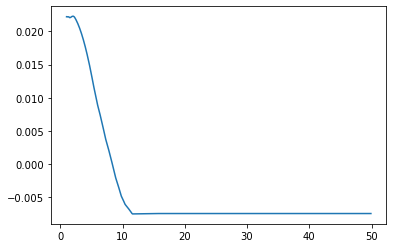

In [106]:
plt.plot(alphas_l, cvs_l)

The algorithm does not seem to converge well with the data, it will not be further considered in this study

## 4- Decision Tree

In [107]:
tree_1 = DecisionTreeRegressor(max_depth = 3)

In [108]:
tree_r2_cv = cross_val_score(tree_1, x_train_sc, y_train_final, scoring = "r2", cv = 10)
tree_rmse_cv = np.abs(cross_val_score(tree_1, x_train_sc, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [109]:
tree_r2_cv_w_features_eliminated = cross_val_score(tree_1, x_train_sc_final, y_train_final, scoring = "r2", cv = 10)
tree_rmse_cv_w_features_eliminated = np.abs(cross_val_score(tree_1, x_train_sc_final, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [110]:
print("The mean R-Squared of Decision Tree model is: {0:.2f}\nThe mean RMSE of Decision Tree model is: {1:.2f}".format(tree_r2_cv.mean(), tree_rmse_cv.mean()))

The mean R-Squared of Decision Tree model is: 0.63
The mean RMSE of Decision Tree model is: 46524.81


In [111]:
print("The mean R-Squared of Decision Tree model with feature elimination is: {0:.2f}\nThe mean RMSE of Decision Tree model with feature elimination is: {1:.2f}".format(tree_r2_cv_w_features_eliminated.mean(), tree_rmse_cv_w_features_eliminated.mean()))

The mean R-Squared of Decision Tree model with feature elimination is: 0.65
The mean RMSE of Decision Tree model with feature elimination is: 46776.30


In [112]:
tree_1.fit(x_train_sc, y_train)

DecisionTreeRegressor(max_depth=3)

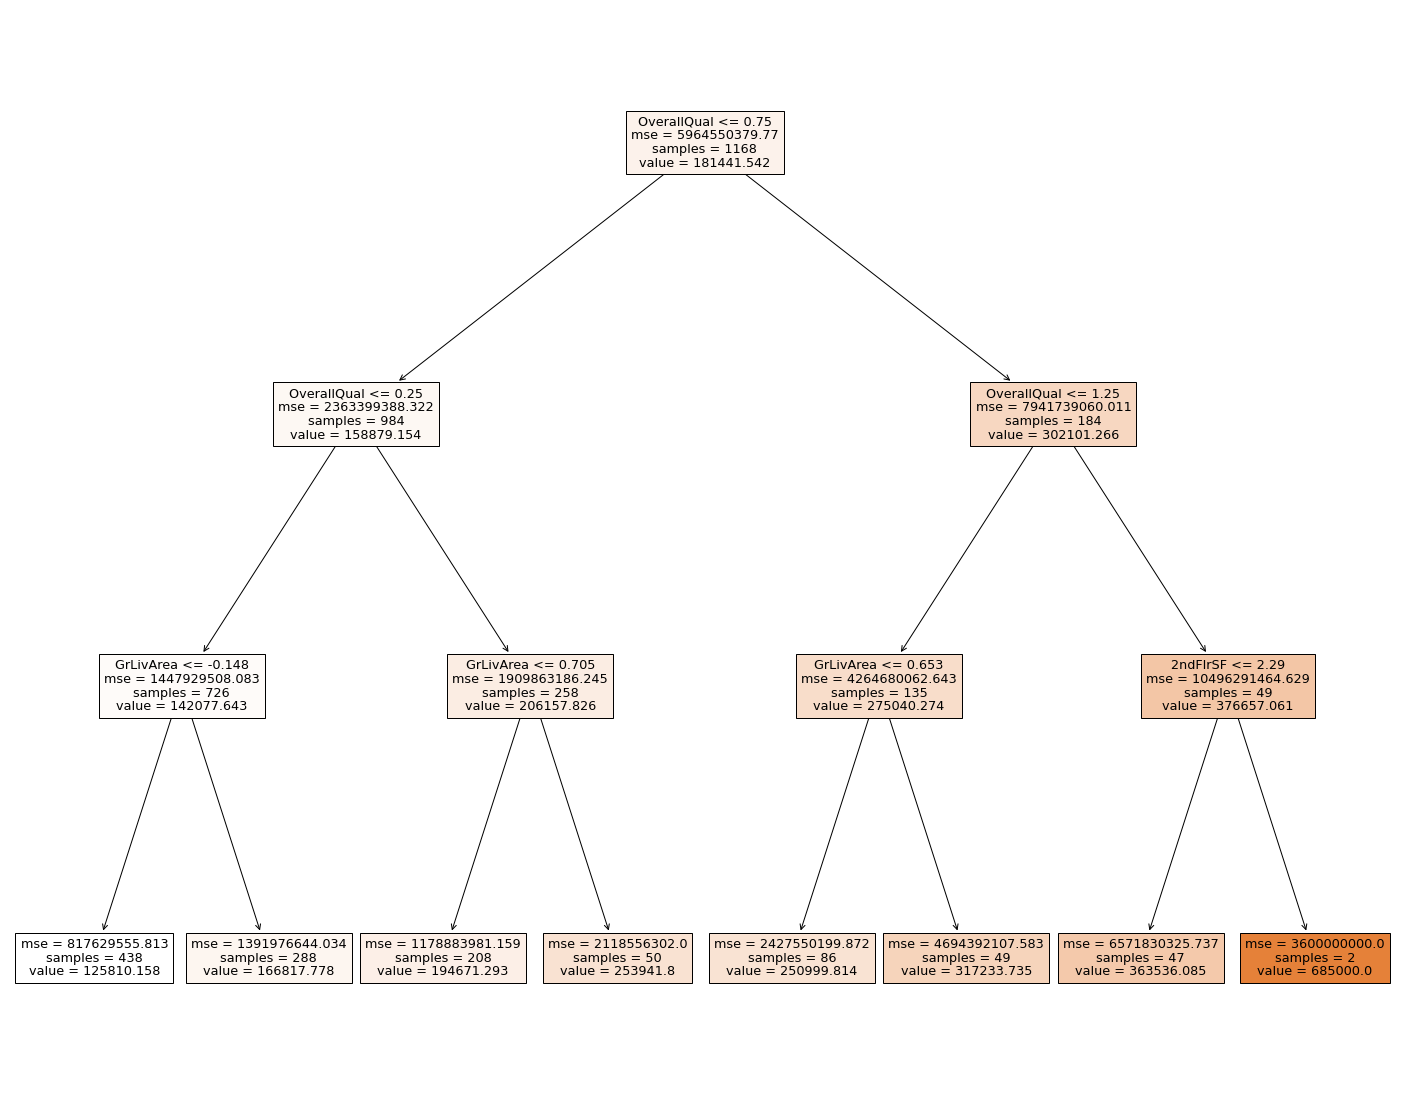

In [113]:
fig = plt.figure(figsize = (25, 20))
plot_tree(tree_1, feature_names = x_train_sc.columns, filled = True)
plt.show()

I see something incorrect here, the same feature is being used in the root node and the first level of nodes as well. That does not make sense

## Ensemble Learning

## 1- Random Forest

In [114]:
forest = RandomForestRegressor(n_estimators = 1000)

In [115]:
forest_r2_cv = cross_val_score(forest, x_train_sc, y_train_final.ravel(), scoring = "r2", cv = 10)
forest_rmse_cv = np.abs(cross_val_score(forest, x_train_sc, y_train.to_numpy().ravel(), scoring = "neg_root_mean_squared_error", cv = 10))

In [116]:
print("The mean R-Squared of Random Forest model is: {0:.2f}\nThe mean RMSE of Random Forest model is: {1:.2f}".format(forest_r2_cv.mean(), forest_rmse_cv.mean()))

The mean R-Squared of Random Forest model is: 0.86
The mean RMSE of Random Forest model is: 29629.68


In [117]:
forest_r2_cv_w_features_eliminated = cross_val_score(forest, x_train_sc_final, y_train_final.ravel(), scoring = "r2", cv = 10)
forest_rmse_cv_w_features_eliminated = np.abs(cross_val_score(forest, x_train_sc_final, y_train.to_numpy().ravel(), scoring = "neg_root_mean_squared_error", cv = 10))

In [118]:
print("The mean R-Squared of Random Forest model is: {0:.2f}\nThe mean RMSE of Random Forest model is: {1:.2f}".format(forest_r2_cv_w_features_eliminated.mean(), forest_rmse_cv_w_features_eliminated.mean()))

The mean R-Squared of Random Forest model is: 0.85
The mean RMSE of Random Forest model is: 30805.31


## 6- Gradient Boosting

In [119]:
xgb = XGBRegressor(booster = "gbtree", max_depth=4, n_estimators=1000, random_state=0, learning_rate=0.01, 
                   min_child_weight=4, subsample=0.7)

In [120]:
xgb_r2_cv = cross_val_score(xgb, x_train_sc, y_train_final, scoring = "r2", cv = 10)
xgb_rmse_cv = np.abs(cross_val_score(xgb, x_train_sc, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [121]:
print("The mean R-Squared of Extreme Gradient Boosting model is: {0:.2f}\nThe mean RMSE of Extreme Gradient Boosting model is: {1:.2f}".format(xgb_r2_cv.mean(), xgb_rmse_cv.mean()))

The mean R-Squared of Extreme Gradient Boosting model is: 0.89
The mean RMSE of Extreme Gradient Boosting model is: 27663.72


In [122]:
xgb_r2_cv_w_features_eliminated = cross_val_score(xgb, x_train_sc_final, y_train_final, scoring = "r2", cv = 10)
xgb_rmse_cv_w_features_eliminated = np.abs(cross_val_score(xgb, x_train_sc_final, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [123]:
print("The mean R-Squared of Extreme Gradient Boosting model is: {0:.2f}\nThe mean RMSE of Extreme Gradient Boosting model is: {1:.2f}".format(xgb_r2_cv_w_features_eliminated.mean(), xgb_rmse_cv_w_features_eliminated.mean()))

The mean R-Squared of Extreme Gradient Boosting model is: 0.88
The mean RMSE of Extreme Gradient Boosting model is: 28932.71


In [124]:
xgb.fit(x_train_sc_final,y_train_final)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<Figure size 1152x432 with 0 Axes>

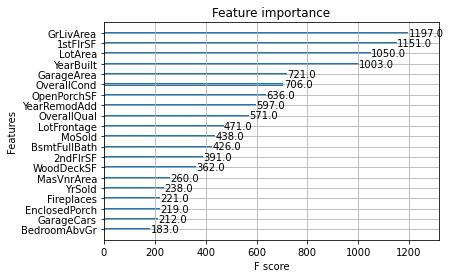

In [125]:
fig = plt.figure(figsize = (16, 6))
plot_importance(xgb, max_num_features = 20);

## Compare Models

In [126]:
allmodels_rmse = dict(LR_RMSE = lm_rmse_cv, Ridge_RMSE = rm_rmse_cv, Tree_RMSE = tree_rmse_cv, Forest_RMSE = forest_rmse_cv, XGB_RMSE = xgb_rmse_cv, Features_eliminated = False)
allmodels_r2 = dict(LR_r2 = lm_r2_cv, Ridge_R2 = rm_r2_cv, Tree_R2 = tree_r2_cv, Forest_R2 = forest_r2_cv, XGB_R2 = xgb_r2_cv, Features_eliminated = False)
allmodels_rmse_w_features_eliminated = dict(LR_RMSE = lm_rmse_cv_w_features_eliminated, Ridge_RMSE = rm_rmse_cv_w_features_eliminated, Tree_RMSE = tree_rmse_cv_w_features_eliminated, Forest_RMSE = forest_rmse_cv_w_features_eliminated, XGB_RMSE = xgb_rmse_cv_w_features_eliminated, Features_eliminated = True)
allmodels_r2_w_features_eliminated = dict(LR_r2 = lm_r2_cv_w_features_eliminated, Ridge_R2 = rm_r2_cv_w_features_eliminated, Tree_R2 = tree_r2_cv_w_features_eliminated, Forest_R2 = forest_r2_cv_w_features_eliminated, XGB_R2 = xgb_r2_cv_w_features_eliminated, Features_eliminated = True)

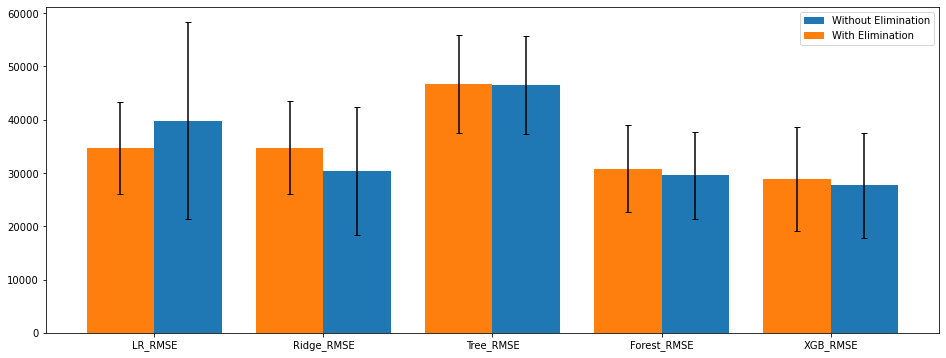

In [127]:
mean_scores = pd.DataFrame(allmodels_rmse).iloc[:, :-1].mean()
std_scores = pd.DataFrame(allmodels_rmse).iloc[:, :-1].std()

mean_scores_2 = pd.DataFrame(allmodels_rmse_w_features_eliminated).iloc[:, :-1].mean()
std_scores_2 = pd.DataFrame(allmodels_rmse_w_features_eliminated).iloc[:, :-1].std()

X_axis = np.arange(len(mean_scores.index))


# Create the bar plot
fig, ax = plt.subplots(figsize = (16, 6))
ax.bar(X_axis + 0.2, mean_scores, 0.4, yerr=std_scores, label = "Without Elimination", capsize = 3)
ax.bar(X_axis - 0.2, mean_scores_2, 0.4, yerr=std_scores_2, label = "With Elimination", capsize = 3)
plt.xticks(X_axis, mean_scores.index)
plt.legend()
plt.show()

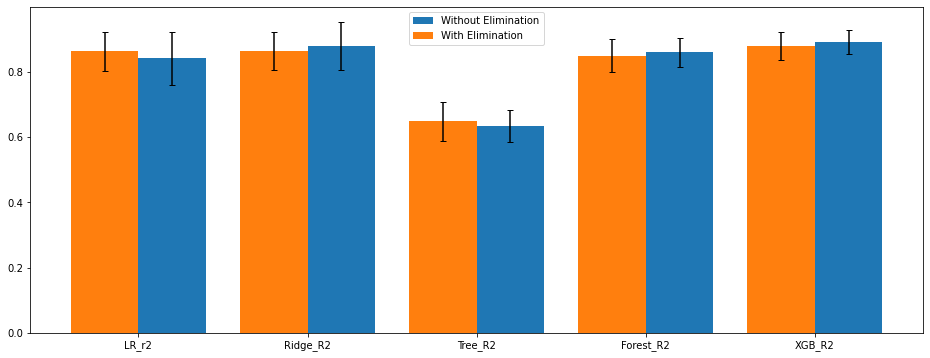

In [128]:
mean_scores = pd.DataFrame(allmodels_r2).iloc[:, :-1].mean()
std_scores = pd.DataFrame(allmodels_r2).iloc[:, :-1].std()

mean_scores_2 = pd.DataFrame(allmodels_r2_w_features_eliminated).iloc[:, :-1].mean()
std_scores_2 = pd.DataFrame(allmodels_r2_w_features_eliminated).iloc[:, :-1].std()

X_axis = np.arange(len(mean_scores.index))


# Create the bar plot
fig, ax = plt.subplots(figsize = (16, 6))
ax.bar(X_axis + 0.2, mean_scores, 0.4, yerr=std_scores, label = "Without Elimination", capsize = 3)
ax.bar(X_axis - 0.2, mean_scores_2, 0.4, yerr=std_scores_2, label = "With Elimination", capsize = 3)
plt.xticks(X_axis, mean_scores.index)
plt.legend()
plt.show()

While the differences may not statistically significant and might be depending on which fold of the data has been used, The XGB model is still the best model. Therefore, it will be used for further development.

## Hyperparameters Tuning

In [129]:
xgb_param = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10], "n_estimators": [500, 600, 700, 800, 900, 1000], "learning_rate": [0.005, 0.01, 0.025, 0.05, 0.075, 0.1], "subsample": [0.5, 0.6, 0.7, 0.8]}

In [130]:
tuning_cv = GridSearchCV(xgb, param_grid = xgb_param, n_jobs = -1)

In [131]:
tuning_cv.fit(x_train_sc_final, y_train_final)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.01, max_bin=256,...
                                    max_delta_step=0, max_depth=4, max_leaves=0,
                                    min_child_weight=4, missing=nan,
                                    monotone_constraints='()',
                                    n_estimators=1000, n_jobs=0,
                            

In [132]:
tun_best = tuning_cv.best_estimator_

In [133]:
tun_xgb_r2_cv = cross_val_score(tun_best, x_train_sc_final, y_train_final, scoring = "r2", cv = 10)
tun_xgb_rmse_cv = np.abs(cross_val_score(tun_best, x_train_sc_final, y_train, scoring = "neg_root_mean_squared_error", cv = 10))

In [134]:
tun_xgb_r2_cv.mean(), tun_xgb_rmse_cv.mean()

(0.8801329166675107, 29412.630564126885)

### Training Data Error Analysis

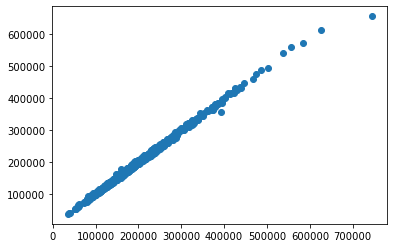

In [135]:
plt.scatter(y_train,pt.inverse_transform(tun_best.predict(x_train_sc_final).reshape(-1,1)))

In [136]:
y_train_prd = pt.inverse_transform(tun_best.predict(x_train_sc_final).reshape(-1,1))

In [139]:
y_train_prd

array([[143725.52],
       [179598.53],
       [ 84771.87],
       ...,
       [117550.06],
       [185181.28],
       [176581.17]], dtype=float32)

In [140]:
resid = y_train_prd - y_train

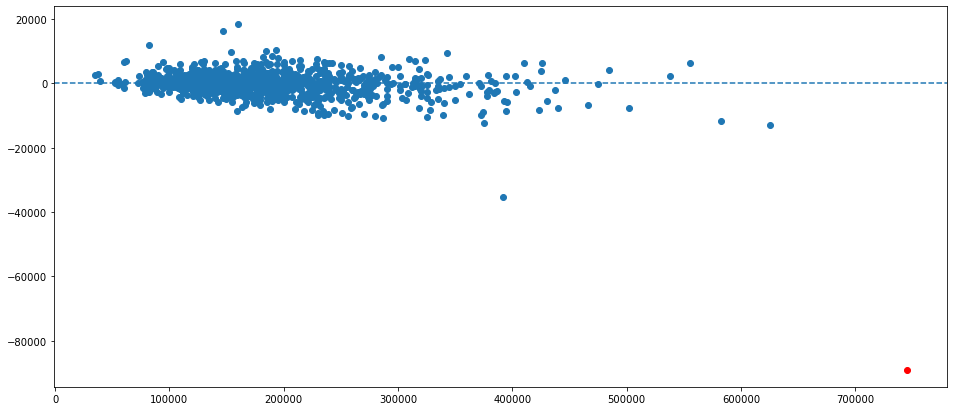

In [141]:
plt.figure(figsize = (16, 7))
plt.scatter(y_train[y_train< 650000], resid[y_train< 650000])
plt.scatter(y_train[y_train > 650000], resid[y_train > 650000], color = "r")
plt.axhline(y = 0, linestyle = "--")

In [142]:
x_train.iloc[np.argmin(resid), :]

MSSubClass             60
MSZoning               RL
LotFrontage      3.267663
LotArea           1.03414
Street               Pave
Alley            No Alley
LotShape              IR1
LandContour           Lvl
Utilities          AllPub
LotConfig          Corner
LandSlope             Gtl
Neighborhood      NoRidge
Condition1           Norm
Condition2           Norm
BldgType             1Fam
HouseStyle         2Story
OverallQual            10
OverallCond             5
YearBuilt            1996
YearRemodAdd         1996
RoofStyle             Hip
RoofMatl          CompShg
Exterior1st       Wd Sdng
Exterior2nd       ImStucc
MasVnrType           None
MasVnrArea            0.0
ExterQual              Gd
ExterCond              TA
Foundation          PConc
BsmtQual               Ex
BsmtCond               TA
BsmtExposure           Av
BsmtFinType1          GLQ
BsmtFinSF1           2096
BsmtFinType2          Unf
BsmtFinSF2              0
BsmtUnfSF             300
TotalBsmtSF          2396
Heating     

### Predictions & Evaluation

In [143]:
y_test_prd = pt.inverse_transform(tun_best.predict(x_test_sc_final).reshape(-1,1))

In [149]:
r2_test = r2_score(y_test_prd, y_test)
print(r2_test)

0.8695943126974419


In [150]:
rmse_test = np.sqrt(mean_squared_error(y_test_prd, y_test))
print(rmse_test)

27836.656477397068


In [147]:
resid_test = y_test_prd - y_test

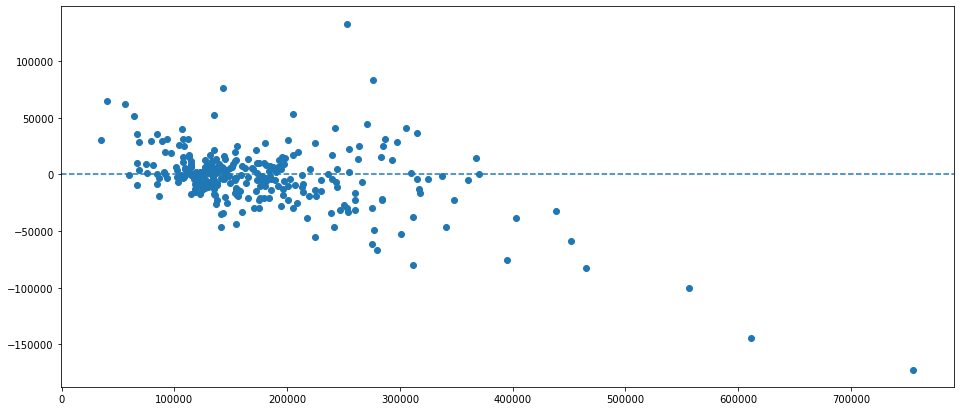

In [148]:
plt.figure(figsize = (16, 7))
plt.scatter(y_test, resid_test)
plt.axhline(y = 0, linestyle = "--")

## Model Interpretability

## 1- Feature Importance

<Figure size 1152x432 with 0 Axes>

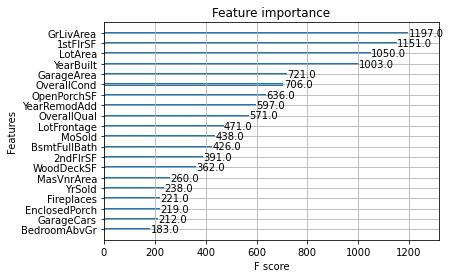

In [151]:
fig = plt.figure(figsize = (16, 6))
plot_importance(xgb, max_num_features = 20);

## 2- SHAP Values

In [152]:
shap_values = shap.TreeExplainer(tun_best).shap_values(x_test_sc_final)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


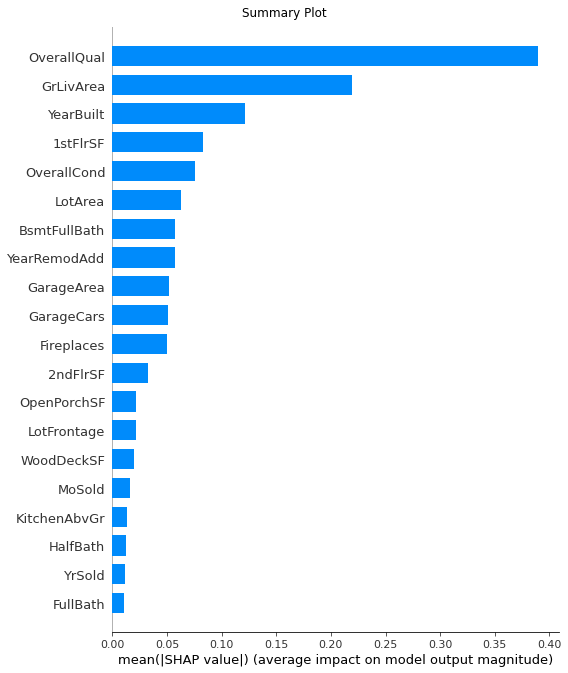

In [153]:
fig = plt.figure()
fig.suptitle("Summary Plot")
shap.summary_plot(shap_values, x_test_sc_final, plot_type = "bar")

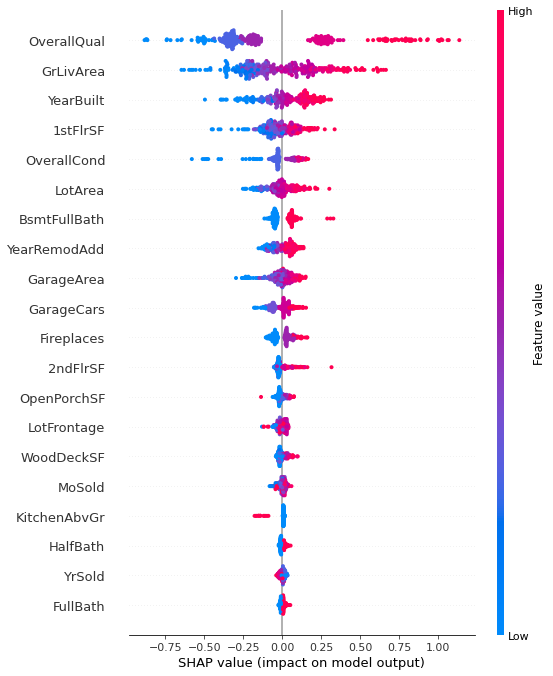

In [154]:
shap.summary_plot(shap_values, x_test_sc_final)

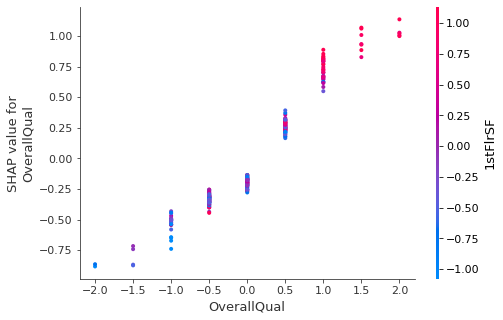

In [155]:
shap.dependence_plot("OverallQual", shap_values, x_test_sc_final)

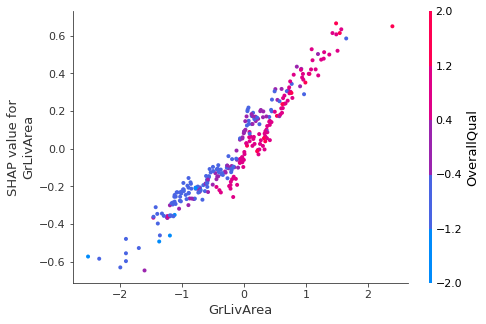

In [156]:
shap.dependence_plot("GrLivArea", shap_values, x_test_sc_final)